<a href="https://colab.research.google.com/github/Sat-A/s5-jax/blob/main/s5-AR-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5-Tokenised

The goal of this exercise is to adapt an annotated implementation of S5 https://github.com/JPGoodale/annotated-s5 that was made for classification tasks to regression tasks.

# Runtime Setup
Ensure runtime is set to GPU to ensure gpu parallelisation speedup

In [2]:
# %%
!pip --quiet install dm-haiku hippox yfinance

In [3]:
# %%
# Core JAX, Haiku, and Optax
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from functools import partial
from typing import NamedTuple, Optional, Tuple, MutableMapping, Any

# Data loading and plotting
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Imports from your original notebook
import torch
from hippox.main import Hippo
from tqdm import tqdm
import dataclasses

First we'll define some helper functions for discretization and timescale initialization as the SSM equation is naturally continuous and must be made discrete to be unrolled as a linear recurrence like standard RNNs.

In [4]:
# Here we are just using the zero order hold method for its sheer simplicity, with A, B and delta_t denoting the
# state matrix, input matrix and change in timescale respectively.

def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity)) * B
    return _A, _B

# This is a function used to initialize the trainable timescale parameter.
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(shape, dtype):
        uniform = hk.initializers.RandomUniform()
        return uniform(shape, dtype)*(jnp.log(dt_max) - jnp.log(dt_min)) + jnp.log(dt_min)
    return init

# Taken directly from https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/recurrent.py
def add_batch(nest, batch_size: Optional[int]):
    broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
    return jax.tree_util.tree_map(broadcast, nest)

The linear SSM equation is as follows:
$$ x_0(t) = Ax(t) + Bu(t) $$
$$ y(t) = Cx(t) + Du(t) $$

 We will now implement it as a recurrent Haiku module:

In [5]:
class LinearSSM(hk.RNNCore):
    def __init__(self, state_size: int, name: Optional[str] = None):
        super(LinearSSM, self).__init__(name=name)
        # We won't get into the basis measure families here, just note that they are basically just the
        # type of orthogonal polynomial we initialize with, the scaled Legendre measure (LegS) introduced
        # in the original HiPPO paper is pretty much the standard initialization and is what is used in the
        # main experiments in the S5 paper. I will also note that the Hippo class uses the diagonal representation
        # of the state matrix by default, as this has become the standard in neural SSMs since shown to be
        # equally effective as the diagonal plus low rank representation in https://arxiv.org/abs/2203.14343
        # and then formalized in https://arxiv.org/abs/2206.11893.

        _hippo = Hippo(state_size=state_size, basis_measure='legs')
        # Must be called for parameters to be initialized
        _hippo()

        # We register the real and imaginary components of the state matrix A as separate parameters because
        # they will have separate gradients in training, they will be conjoined back together and then discretized
        # but this will simply be backpropagated through as a transformation of the lambda real and imaginary
        # parameters (lambda is just what we call the diagonalized state matrix).

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            shape=[state_size,],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            shape=[state_size,],
            init=_hippo.lambda_initializer('imaginary')
        )
        self._A = self._lambda_real + 1j * self._lambda_imag

       # For now, these initializations of the input and output matrices B and C match the S4D
        # parameterization for demonstration purposes, we will implement the S5 versions later.

        self._B = hk.get_parameter(
            'B',
            shape=[state_size,],
            init=_hippo.b_initializer()
        )
        self._C = hk.get_parameter(
            'C',
            shape=[state_size, 2],
            init=hk.initializers.RandomNormal(stddev=0.5**0.5)
        )
        self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        # This feed-through matrix basically acts as a residual connection.
        self._D = hk.get_parameter(
            'D',
            [1,],
            init=jnp.ones,
        )

        self._delta_t = hk.get_parameter(
            'delta_t',
            shape=[1,],
            init=log_step_initializer()
        )
        timescale = jnp.exp(self._delta_t)

        self._state_matrix, self._input_matrix = discretize(self._A, self._B, timescale)

    def __call__(self, inputs, prev_state):
        u = inputs[:, jnp.newaxis]
        new_state = self._state_matrix @ prev_state + self._input_matrix @ u
        y_s = self._output_matrix @ new_state
        out = y_s.reshape(-1).real + self._D * u
        return out, new_state

    def initial_state(self, batch_size: Optional[int] = None):
        state = jnp.zeros([self._state_size])
        if batch_size is not None:
            state = add_batch(state, batch_size)
        return state

You may notice that this looks an awful lot like a vanilla RNN cell, just with our special parameterization and without any activations, hence being a linear recurrence. I have initialized it as an instance of Haiku's RNN.Core abstract base class so that it can be unrolled using either the hk.dynamic_unroll or hk.static_unroll functions like any other recurrent module, however, if you are familiar with any of the S4 models you may be noticing that there's something crucial missing here: the convolutional representation. One of the key contributions of the S4 paper was its demonstration that the SSM ODE can be represented as either a linear recurrence, as above, for efficient inference, or as a global convolution for much faster training. That paper and the following papers then go on to present various kernels for efficiently computing this convolution with Fast Fourier Transforms, highly improving the computational efficiency of the model. Then why have we omitted them? Because the S5 architecture which we are about to explore simplifies all this by providing a purely recurrent representation in both training and inference, it does this by using a parallel recurrence that actually looks alot like a convolution itself! From the paper:

    "We use parallel scans to efficiently compute the states of a discretized linear SSM. Given a binary associative operator • (i.e. (a • b) • c = a • (b • c)) and a sequence of L elements [a1, a2, ..., aL], the scan operation (sometimes referred to as all-prefix-sum) returns the sequence [a1, (a1 • a2), ..., (a1 • a2 • ... • aL)]."

Let's see what this looks like in code, taken straight from the original author's implementation:

In [6]:
@jax.vmap
def binary_operator(q_i, q_j):
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

def parallel_scan(A, B, C, inputs):
    A_elements = A * jnp.ones((inputs.shape[0], A.shape[0]))
    Bu_elements = jax.vmap(lambda u: B @ u)(inputs)
    # Jax's built-in associative scan really comes in handy here as it executes a similar scan
    # operation as used in a normal recurrent unroll but is specifically tailored to fit an associative
    # operation like the one described in the paper.
    _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))
    return jax.vmap(lambda x: (C @ x).real)(xs)

It's that simple! In the original S4 we would have had to apply an independent singe-input, single-output (SISO) SSM for each feature of the input sequence such as in this excerpt from Sasha Rush's Flax implementation:



```python
def cloneLayer(layer):
    return flax.linen.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)
```



Whereas in the S5 we process the entire sequence in one multi-input, multi-output (MIMO) layer.

Let's now rewrite our Module as a full S5 layer using this new method, we will be adding a few extra conditional arguments as well as changing some parameterization to match the original paper, but we'll walk through the reason for all these changes below.

In [7]:
# First we add a new helper function for the timescale initialization, this one just takes the previous
# log_step_initializer and stores a bunch of them in an array since our model is now multi-in, multi-out.

def init_log_steps(shape, dtype):
    H = shape[0]
    log_steps = []
    for i in range(H):
        log_step = log_step_initializer()(shape=(1,), dtype=dtype)
        log_steps.append(log_step)

    return jnp.array(log_steps)

In [8]:
# We will also rewrite our discretization for the MIMO context
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity))[..., None] * B
    return _A, _B

In [9]:
class S5(hk.Module):
    def __init__(self,
                 state_size: int,

                 # Now that we're MIMO we'll need to know the number of input features, commonly
                 # referred to as the dimension of the model.
                 d_model: int,

                 # We must also now specify the number of blocks that we will split our matrices
                 # into due to the MIMO context.
                 n_blocks: int,

                 # Short for conjugate symmetry, because our state matrix is complex we can half
                 # the size of it since complex numbers are a real and imaginary number joined together,
                 # this is not new to the S5, we just didn't mention it above.
                 conj_sym: bool = True,

                 # Another standard SSM argument that we omitted above for simplicity's sake,
                 # this forces the real part of the state matrix to be negative for better
                 # stability, especially in autoregressive tasks.
                 clip_eigns: bool = False,

                 # Like most RNNs, the S5 can be run in both directions if need be.
                 bidirectional: bool = False,

                 # Rescales delta_t for varying input resolutions, such as different audio
                 # sampling rates.
                 step_rescale: float = 1.0,
                 name: Optional[str] = None
    ):
        super(S5, self).__init__(name=name)
        self.conj_sym = conj_sym
        self.bidirectional = bidirectional

        # Note that the Hippo class takes conj_sym as an argument and will automatically half
        # the state size provided in its initialization, which is why we need to provide a local
        # state size that matches this for the shape argument in hk.get_parameter().

        if conj_sym:
            _state_size = state_size // 2
        else:
            _state_size = state_size

        # With block_diagonal set as True and the number of blocks provided, our Hippo class
        # will automatically handle this change of structure.

        _hippo = Hippo(
            state_size=state_size,
            basis_measure='legs',
            conj_sym=conj_sym,
            block_diagonal=True,
            n_blocks=n_blocks,
        )
        _hippo()

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            [_state_size],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            [_state_size],
            init=_hippo.lambda_initializer('imaginary')
        )
        if clip_eigns:
            self._lambda = jnp.clip(self._lambda_real, None, -1e-4) + 1j * self._lambda_imag
        else:
            self._A = self._lambda_real + 1j * self._lambda_imag

        # If you recall, I mentioned above that we are automatically using a diagonalized version of
        # the HiPPO state matrix rather than the pure one, due to it being very hard to efficiently
        # compute. I will now go into a little more detail on how this diagonal representation is
        # derived, as it is important for how we initialize the input and output matrices. The diagonal
        # decomposition of our state matrix is based on equivalence relation on the SSM parameters:
        # (A, B, C) ∼ (V−1AV ,V−1B, CV) with V being the eigenvector of our original A matrix and V-1
        # being the inverse eigenvector. The Hippo class has already performed the decomposition of A
        # into (V-1AV) automatically, but we have not yet performed the decomposition of B and C, we will
        # use the eigenvector_transform class method for that below, but first we must initialize B and C
        # as normal distributions, lecun normal and truncated normal respectively. I will note that there
        # are a few other options provided for C in the original repository but, to keep it simple, we will
        # just use one here.

        b_init = hk.initializers.VarianceScaling()
        b_shape = [state_size, d_model]
        b_init = b_init(b_shape, dtype=jnp.complex64)
        self._B = hk.get_parameter(
            'B',
            [_state_size, d_model, 2],
            init=_hippo.eigenvector_transform(b_init,  concatenate=True),
        )
        B = self._B[..., 0] + 1j * self._B[..., 1]

        c_init = hk.initializers.TruncatedNormal()
        c_shape = [d_model, state_size, 2]
        c_init = c_init(c_shape, dtype=jnp.complex64)
        self._C = hk.get_parameter(
            'C',
            [d_model, _state_size, 2],
            init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
        )
        # We need two output heads if bidirectional is True.
        if bidirectional:
            self._C2 = hk.get_parameter(
                'C2',
                [d_model, _state_size, 2],
                init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
            )
            C1 = self._C[..., 0] + 1j * self._C[..., 1]
            C2 = self._C2[..., 0] + 1j * self._C2[..., 1]
            self._output_matrix = jnp.concatenate((C1, C2), axis=-1)
        else:
            self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter(
            'D',
            [d_model,],
            init=hk.initializers.RandomNormal(stddev=1.0)
        )

        self._delta_t = hk.get_parameter(
            'delta_T',
            [_state_size, 1],
            init=init_log_steps
        )
        timescale = step_rescale * jnp.exp(self._delta_t[:, 0])

        # We could also use the bilinear discretization method, but we'll just stick to zoh for now.
        self._state_matrix, self._input_matrix = discretize(self._A, B, timescale)


    def __call__(self, inputs):
        # Note that this is the exact same function as presented above just with alternate procedures
        # depending on the bidirectional and conjugate symmetry arguments

        A_elements = self._state_matrix * jnp.ones((inputs.shape[0], self._state_matrix.shape[0]))
        Bu_elements = jax.vmap(lambda u: self._input_matrix @ u)(inputs)

        _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))

        if self.bidirectional:
            _, xs2 = jax.lax.associative_scan(binary_operator,
                                          (A_elements, Bu_elements),
                                          reverse=True)
            xs = jnp.concatenate((xs, xs2), axis=-1)

        if self.conj_sym:
            ys = jax.vmap(lambda x: 2*(self._output_matrix @ x).real)(xs)
        else:
            ys = jax.vmap(lambda x: (self._output_matrix @ x).real)(xs)

        Du = jax.vmap(lambda u: self._D * u)(inputs)

        return ys + Du

There we have it, a complete S5 layer! Now let's form a block around it using a structure very similar to a transformer block with a Gated Linear Unit (GLU).

In [10]:
import dataclasses

@dataclasses.dataclass
class S5Block(hk.Module):
    ssm: S5
    d_model: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Block, self).__post_init__()
        # We could use either layer norm or batch norm.
        self._norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
        self._linear = hk.Linear(self.d_model)

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self._norm(x)

        x = self.ssm(x)
        # There are a couple of other GLU patterns we could use here, but once again I have chosen
        # one semi-arbitrarily to avoid cluttering our module with if statements.
        x1 = hk.dropout(hk.next_rng_key(), self.dropout_rate, jax.nn.gelu(x))
        x = x * jax.nn.sigmoid(self._linear(x1))
        x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        x = skip + x
        if not self.prenorm:
            x = self._norm(x)

        return x

Now let's make a stack of these blocks:

In [11]:
@dataclasses.dataclass
class S5Stack(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Stack, self).__post_init__(name=self.name)
        self._encoder = hk.Linear(self.d_model)
        self._layers = [
            S5Block(
                ssm=self.ssm,
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                istraining=self.istraining,
                prenorm=self.prenorm,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        x = self._encoder(x)
        for layer in self._layers:
            x = layer(x)
        return x

# Implementing Tokenised prediction in S5

In [12]:
# %%
# --- S5 Model Hyperparameters (INCREASED) ---
STATE_SIZE: int = 256        # Increased from 128
D_MODEL: int = 128           # Increased from 64
N_LAYERS: int = 6            # Increased from 3
N_BLOCKS: int = 4
DROPOUT_RATE: float = 0.1

# --- Task & Training Hyperparameters ---
VOCAB_SIZE: int = 1024       # Number of "price bins"
SEQ_LEN: int = 256         # Input sequence length (256 days)
BATCH_SIZE: int = 64
EPOCHS: int = 30           # Increased from 10 for better training
LEARNING_RATE: float = 1e-3  # This will be the *peak* learning rate
SEED = 0

# --- Set random seeds ---
torch.random.manual_seed(SEED)
key = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(key)

In [13]:
# %%
class StockPriceTokeniser:
    """
    A simple quantisation tokeniser.
    Converts continuous stock prices into discrete integer tokens.
    """
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.bins = None
        self.min_price = 0.0
        self.max_price = 1.0

    def fit(self, data: jnp.ndarray):
        """Fits the tokeniser to the data to find min/max prices."""
        self.min_price = data.min()
        self.max_price = data.max()
        # Create vocab_size-1 thresholds for binning
        self.bins = jnp.linspace(self.min_price, self.max_price, self.vocab_size - 1)
        print(f"[*] Tokeniser fitted: min={self.min_price:.2f}, max={self.max_price:.2f}")

    def encode(self, prices: jnp.ndarray) -> jnp.ndarray:
        """Converts a sequence of prices into token IDs."""
        if self.bins is None:
            raise ValueError("Tokeniser must be fitted before encoding.")
        token_ids = jnp.digitize(prices, self.bins)
        return token_ids.astype(jnp.int32)

    def decode(self, token_ids: jnp.ndarray) -> jnp.ndarray:
        """Converts a sequence of token IDs back into approximate prices (bin centres)."""
        if self.bins is None:
            raise ValueError("Tokeniser must be fitted before decoding.")

        bin_edges = jnp.concatenate([
            jnp.array([self.min_price]),
            self.bins,
            jnp.array([self.max_price])
        ])
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        prices = bin_centres[token_ids]
        return prices

In [14]:
# %%
@dataclasses.dataclass
class S5Forecaster(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    vocab_size: int
    dropout_rate: float
    prenorm: bool = True
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Forecaster, self).__post_init__(name=self.name)

        self._embedding = hk.Embed(
            vocab_size=self.vocab_size,
            embed_dim=self.d_model
        )

        self._s5_stack = S5Stack(
            ssm=self.ssm,
            d_model=self.d_model,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            istraining=self.istraining,
            prenorm=self.prenorm,
        )

        self._decoder = hk.Linear(self.vocab_size)

    def __call__(self, token_ids: jnp.ndarray) -> jnp.ndarray:
        x = self._embedding(token_ids)
        x = self._s5_stack(x)
        logits = self._decoder(x)
        return logits

In [15]:
# %%
# --- Training State and Optimizer ---
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jnp.ndarray

# Note: The optimizer ('optim') will be created in Cell 10
# after we know the total number of training steps.
_Metrics = MutableMapping[str, Any]

# --- Loss and Accuracy Functions ---
def loss_fn(
    params: hk.Params,
    rng_key: jnp.ndarray,
    model: hk.Transformed,
    inputs: jnp.ndarray, # Shape [Batch, SeqLen]
    targets: jnp.ndarray # Shape [Batch, SeqLen]
) -> jnp.ndarray:

    logits = model.apply(params, rng_key, inputs)
    loss_per_token = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits,
        labels=targets
    )
    return jnp.mean(loss_per_token)

def accuracy_fn(
    params: hk.Params,
    rng_key: jnp.ndarray,
    model: hk.Transformed,
    inputs: jnp.ndarray,
    targets: jnp.ndarray
) -> jnp.ndarray:

    logits = model.apply(params, rng_key, inputs)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == targets)
    return accuracy

# --- Update and Evaluate Functions ---
@partial(jax.jit, static_argnums=(2,))
def update(
    state: TrainingState,
    batch: Tuple[jnp.ndarray, jnp.ndarray],
    model: hk.Transformed,
) -> Tuple[TrainingState, _Metrics]:

    inputs, targets = batch
    rng_key, next_rng_key = jax.random.split(state.rng_key)

    (loss, gradients) = jax.value_and_grad(loss_fn)(
        state.params,
        rng_key,
        model,
        inputs,
        targets
    )

    updates, new_opt_state = optim.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng_key=next_rng_key,
    )

    metrics = {'loss': loss}
    return new_state, metrics


@partial(jax.jit, static_argnums=(2,))
def evaluate(
    state: TrainingState,
    batch: Tuple[jnp.ndarray, jnp.ndarray],
    model: hk.Transformed,
) -> _Metrics:

    inputs, targets = batch
    loss = loss_fn(state.params, state.rng_key, model, inputs, targets)
    accuracy = accuracy_fn(state.params, state.rng_key, model, inputs, targets)

    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

In [16]:
# %%
# ⭐️ CHANGED: Switched from argmax (greedy) to sampling
@partial(jax.jit, static_argnums=(0, 2)) # Removed '4' from static_argnums
def generate_forecast(
    model_init_fn, # arg 0 (static)
    params: hk.Params, # arg 1 (dynamic)
    steps_to_forecast: int, # arg 2 (static)
    prompt_tokens: jnp.ndarray, # arg 3 (dynamic)
    rng_key: jnp.ndarray # arg 4 (dynamic)
):

    # Define the forward function for generation (istraining=False)
    @hk.transform
    def forward_generate(x) -> hk.transform:
        s5_ssm = S5(STATE_SIZE, D_MODEL, N_BLOCKS)
        neural_net = S5Forecaster(
            ssm=s5_ssm,
            d_model=D_MODEL,
            n_layers=N_LAYERS,
            vocab_size=VOCAB_SIZE,
            dropout_rate=0.0,
            istraining=False,
        )
        return neural_net(x) # No vmap, processes one sequence

    def scan_body(carry, _):
        current_tokens, rng_key = carry

        logits = forward_generate.apply(params, rng_key, current_tokens)
        last_token_logits = logits[-1]

        # ⭐️ CHANGE: Use sampling (jax.random.categorical) instead of argmax
        # Split the key for this sampling step
        rng_key, subkey = jax.random.split(rng_key)
        next_token = jax.random.categorical(subkey, last_token_logits)
        next_token = next_token.astype(jnp.int32)

        new_tokens = jnp.roll(current_tokens, -1)
        new_tokens = new_tokens.at[-1].set(next_token)

        return (new_tokens, rng_key), next_token

    initial_carry = (prompt_tokens, rng_key)

    _, predicted_token_sequence = jax.lax.scan(
        scan_body, initial_carry, None, length=steps_to_forecast
    )

    return predicted_token_sequence

In [17]:
# %%
# --- 1. Fetch Real Stock Data ---
print("[*] Fetching stock data for 'SPY'...")
ticker = "SPY"
start_date = "2010-01-01"
end_date = "2024-01-01"
stock_data_df = yf.download(ticker, start=start_date, end=end_date)

print("--- Stock Data Head ---")
print(stock_data_df.head())
print(f"\nLoaded {len(stock_data_df)} days of data.")

# This line should use single brackets ['Adj Close'] to get a 1D array
# But even if you use double brackets, the fix below will handle it.
price_data = stock_data_df['Close'].values
price_data = jnp.array(price_data)

# --- 2. Tokenise and Split Data ---
print("\n[*] Fitting tokeniser...")
tokeniser = StockPriceTokeniser(vocab_size=VOCAB_SIZE)
tokeniser.fit(price_data)
token_data = tokeniser.encode(price_data) # This may be [N] or [N, 1]

split_idx = int(len(token_data) * 0.9)
train_data_tokens = token_data[:split_idx]
val_data_tokens = token_data[split_idx:]

print(f"\nTotal samples: {len(token_data)}")
print(f"Training samples: {len(train_data_tokens)}")
print(f"Validation samples: {len(val_data_tokens)}")

# --- 3. Create Sliding Windows ---
def create_sliding_windows(data: jnp.ndarray, seq_len: int):
    """Creates (input, target) pairs from a token array."""
    inputs, targets = [], []

    # Squeeze the data to ensure it's 1D (e.g., [N, 1] -> [N])
    # This is the key fix.
    if data.ndim > 1:
        data = data.squeeze()

    for i in range(len(data) - seq_len):
        # Slicing a 1D array gives a 1D array
        inputs.append(data[i : i + seq_len])
        targets.append(data[i + 1 : i + seq_len + 1])

    # Stacking 1D arrays gives a 2D array
    return jnp.stack(inputs), jnp.stack(targets)

print("\n[*] Creating sliding windows...")
train_inputs, train_targets = create_sliding_windows(train_data_tokens, SEQ_LEN)
val_inputs, val_targets = create_sliding_windows(val_data_tokens, SEQ_LEN)

print(f"Created {len(train_inputs)} training sequences.")
print(f"Created {len(val_inputs)} validation sequences.")

# Create batch iterators
num_train_batches = len(train_inputs) // BATCH_SIZE
train_batches = []
for i in range(num_train_batches):
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    train_batches.append((train_inputs[start:end], train_targets[start:end]))

val_batch = (val_inputs[:BATCH_SIZE], val_targets[:BATCH_SIZE])

# This dummy_batch will now have the correct shape [64, 256]
dummy_batch = train_batches[0][0]
print(f"\n[*] Dummy batch shape: {dummy_batch.shape}, Dtype: {dummy_batch.dtype}")

[*] Fetching stock data for 'SPY'...


/tmp/ipython-input-2871985539.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


--- Stock Data Head ---
Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.279221  85.324368  83.909697  84.556835  118944600
2010-01-05  85.504982  85.542609  84.918044  85.226566  111579900
2010-01-06  85.565117  85.775812  85.354422  85.422143  116074400
2010-01-07  85.926323  86.031670  85.166311  85.407106  131091100
2010-01-08  86.212280  86.249907  85.527521  85.700590  126402800

Loaded 3522 days of data.

[*] Fitting tokeniser...
[*] Tokeniser fitted: min=77.59, max=466.56

Total samples: 3522
Training samples: 3169
Validation samples: 353

[*] Creating sliding windows...
Created 2913 training sequences.
Created 97 validation sequences.

[*] Dummy batch shape: (64, 256), Dtype: int32


In [18]:
# %%
# --- 4. Initialise Model ---
@hk.transform
def forward(x) -> hk.transform:
    s5_ssm = S5(STATE_SIZE, D_MODEL, N_BLOCKS)

    neural_net = S5Forecaster(
        ssm=s5_ssm,
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        vocab_size=VOCAB_SIZE,
        dropout_rate=DROPOUT_RATE,
        istraining=True
    )
    return hk.vmap(neural_net, in_axes=0, split_rng=False)(x)

print("[*] Initialising model parameters...")
initial_params = forward.init(init_rng, dummy_batch)

# ⭐️ CHANGED: Create the learning rate schedule
print("[*] Creating learning rate schedule...")
num_train_batches = len(train_batches)
total_steps = num_train_batches * EPOCHS
warmup_steps = int(total_steps * 0.1)  # 10% of total steps for warmup

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=LEARNING_RATE,
    warmup_steps=warmup_steps,
    decay_steps=total_steps - warmup_steps,
    end_value=1e-5
)

optim = optax.adam(schedule)
initial_opt_state = optim.init(initial_params)

state = TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng_key=rng
)

param_count = sum(x.size for x in jax.tree_util.tree_leaves(initial_params))
print(f"Model initialised. Parameter count: {param_count:,}")
print(f"Total training steps: {total_steps}, Warmup steps: {warmup_steps}")

[*] Initialising model parameters...


/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:1660: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)  # type: ignore[unused-ignore,bad-return-type]


[*] Creating learning rate schedule...
Model initialised. Parameter count: 446,336
Total training steps: 1350, Warmup steps: 135


In [19]:
# %%
# --- 5. Training Loop ---
print("\n[*] Starting training...")
for epoch in range(EPOCHS):
    epoch_losses = []

    pbar = tqdm(train_batches, desc=f"Epoch {epoch + 1}/{EPOCHS} [Train]")
    for batch in pbar:
        state, metrics = update(state, batch, forward)
        epoch_losses.append(metrics['loss'])
        pbar.set_postfix(loss=f"{metrics['loss']:.4f}")

    train_loss = jnp.mean(jnp.array(epoch_losses))
    val_metrics = evaluate(state, val_batch, forward)

    print(
        f"\n=>> Epoch {epoch + 1} Metrics ===\n"
        f"\tTrain Loss: {train_loss:.5f}\n"
        f"\t Val. Loss: {val_metrics['loss']:.5f} -- Val. Accuracy: {val_metrics['accuracy']:.4f}"
    )

print("[*] Training complete.")


[*] Starting training...


Epoch 1/30 [Train]:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
Epoch 1/30 [Train]: 100%|██████████| 45/45 [00:28<00:00,  1.59it/s, loss=23.2940]



=>> Epoch 1 Metrics ===
	Train Loss: 31.58281
	 Val. Loss: 22.67353 -- Val. Accuracy: 0.0033


Epoch 2/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.35it/s, loss=11.5795]



=>> Epoch 2 Metrics ===
	Train Loss: 15.89347
	 Val. Loss: 12.54003 -- Val. Accuracy: 0.0008


Epoch 3/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.70it/s, loss=7.9974]



=>> Epoch 3 Metrics ===
	Train Loss: 8.78299
	 Val. Loss: 9.50619 -- Val. Accuracy: 0.0002


Epoch 4/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.08it/s, loss=6.7721]



=>> Epoch 4 Metrics ===
	Train Loss: 6.53416
	 Val. Loss: 8.95118 -- Val. Accuracy: 0.0006


Epoch 5/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.27it/s, loss=6.0229]



=>> Epoch 5 Metrics ===
	Train Loss: 5.35021
	 Val. Loss: 9.06300 -- Val. Accuracy: 0.0002


Epoch 6/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.48it/s, loss=5.2011]



=>> Epoch 6 Metrics ===
	Train Loss: 4.34936
	 Val. Loss: 9.19095 -- Val. Accuracy: 0.0002


Epoch 7/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.47it/s, loss=4.4558]



=>> Epoch 7 Metrics ===
	Train Loss: 3.52745
	 Val. Loss: 9.51058 -- Val. Accuracy: 0.0002


Epoch 8/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.55it/s, loss=3.6918]



=>> Epoch 8 Metrics ===
	Train Loss: 2.85109
	 Val. Loss: 9.69590 -- Val. Accuracy: 0.0008


Epoch 9/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.61it/s, loss=3.0450]



=>> Epoch 9 Metrics ===
	Train Loss: 2.21893
	 Val. Loss: 9.94320 -- Val. Accuracy: 0.0001


Epoch 10/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.30it/s, loss=2.3961]



=>> Epoch 10 Metrics ===
	Train Loss: 1.75742
	 Val. Loss: 10.14823 -- Val. Accuracy: 0.0005


Epoch 11/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.28it/s, loss=1.9377]



=>> Epoch 11 Metrics ===
	Train Loss: 1.37439
	 Val. Loss: 10.24187 -- Val. Accuracy: 0.0015


Epoch 12/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.39it/s, loss=1.6108]



=>> Epoch 12 Metrics ===
	Train Loss: 1.12082
	 Val. Loss: 10.45842 -- Val. Accuracy: 0.0010


Epoch 13/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.29it/s, loss=1.3522]



=>> Epoch 13 Metrics ===
	Train Loss: 0.91307
	 Val. Loss: 10.57644 -- Val. Accuracy: 0.0009


Epoch 14/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.30it/s, loss=1.1550]



=>> Epoch 14 Metrics ===
	Train Loss: 0.79295
	 Val. Loss: 10.69103 -- Val. Accuracy: 0.0009


Epoch 15/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.16it/s, loss=1.0099]



=>> Epoch 15 Metrics ===
	Train Loss: 0.69674
	 Val. Loss: 10.84146 -- Val. Accuracy: 0.0011


Epoch 16/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.17it/s, loss=0.8857]



=>> Epoch 16 Metrics ===
	Train Loss: 0.62470
	 Val. Loss: 10.89299 -- Val. Accuracy: 0.0011


Epoch 17/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.24it/s, loss=0.8108]



=>> Epoch 17 Metrics ===
	Train Loss: 0.56256
	 Val. Loss: 11.00776 -- Val. Accuracy: 0.0012


Epoch 18/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.14it/s, loss=0.7299]



=>> Epoch 18 Metrics ===
	Train Loss: 0.51343
	 Val. Loss: 11.09282 -- Val. Accuracy: 0.0018


Epoch 19/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.12it/s, loss=0.6743]



=>> Epoch 19 Metrics ===
	Train Loss: 0.47824
	 Val. Loss: 11.17855 -- Val. Accuracy: 0.0015


Epoch 20/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.93it/s, loss=0.6332]



=>> Epoch 20 Metrics ===
	Train Loss: 0.45541
	 Val. Loss: 11.22617 -- Val. Accuracy: 0.0015


Epoch 21/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.81it/s, loss=0.6079]



=>> Epoch 21 Metrics ===
	Train Loss: 0.43785
	 Val. Loss: 11.24803 -- Val. Accuracy: 0.0012


Epoch 22/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 20.03it/s, loss=0.5853]



=>> Epoch 22 Metrics ===
	Train Loss: 0.42512
	 Val. Loss: 11.27141 -- Val. Accuracy: 0.0016


Epoch 23/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.89it/s, loss=0.5749]



=>> Epoch 23 Metrics ===
	Train Loss: 0.41498
	 Val. Loss: 11.29713 -- Val. Accuracy: 0.0022


Epoch 24/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.98it/s, loss=0.5611]



=>> Epoch 24 Metrics ===
	Train Loss: 0.41129
	 Val. Loss: 11.30089 -- Val. Accuracy: 0.0011


Epoch 25/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.66it/s, loss=0.5626]



=>> Epoch 25 Metrics ===
	Train Loss: 0.40399
	 Val. Loss: 11.29244 -- Val. Accuracy: 0.0018


Epoch 26/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.58it/s, loss=0.5636]



=>> Epoch 26 Metrics ===
	Train Loss: 0.40389
	 Val. Loss: 11.31663 -- Val. Accuracy: 0.0015


Epoch 27/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.79it/s, loss=0.5613]



=>> Epoch 27 Metrics ===
	Train Loss: 0.40169
	 Val. Loss: 11.29499 -- Val. Accuracy: 0.0013


Epoch 28/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.79it/s, loss=0.5526]



=>> Epoch 28 Metrics ===
	Train Loss: 0.40110
	 Val. Loss: 11.35729 -- Val. Accuracy: 0.0016


Epoch 29/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.70it/s, loss=0.5472]



=>> Epoch 29 Metrics ===
	Train Loss: 0.39992
	 Val. Loss: 11.30927 -- Val. Accuracy: 0.0015


Epoch 30/30 [Train]: 100%|██████████| 45/45 [00:02<00:00, 19.54it/s, loss=0.5503]



=>> Epoch 30 Metrics ===
	Train Loss: 0.39961
	 Val. Loss: 11.31811 -- Val. Accuracy: 0.0021
[*] Training complete.


[*] Generating forecast...
[*] Decoding and plotting results...


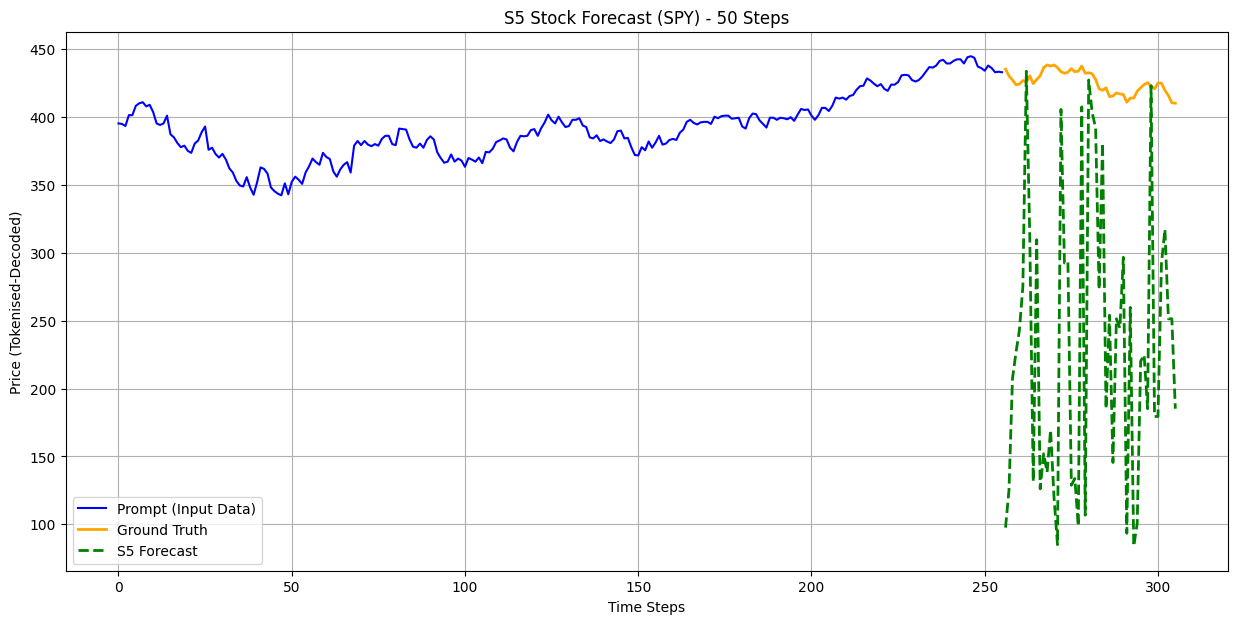

Plot saved to s5_stock_forecast.png


<Figure size 640x480 with 0 Axes>

In [20]:
# %%
# --- 6. Generate Forecast ---
print("[*] Generating forecast...")
FORECAST_HORIZON = 50 # Predict the next 50 days

# Create a prompt from the validation set
# We take the first validation sequence as our prompt
prompt_tokens = val_inputs[0] # Shape [256]

# Get the corresponding ground truth
# The ground truth tokens are the 50 tokens that follow the prompt
ground_truth_tokens = val_data_tokens[SEQ_LEN : SEQ_LEN + FORECAST_HORIZON]

# Generate new token IDs
predicted_tokens = generate_forecast(
    forward.init, # Pass the init function
    state.params,
    FORECAST_HORIZON,
    prompt_tokens,
    state.rng_key
)

# --- 7. Decode and Plot Results ---
print("[*] Decoding and plotting results...")
predicted_prices = tokeniser.decode(predicted_tokens)
ground_truth_prices = tokeniser.decode(ground_truth_tokens)
prompt_prices = tokeniser.decode(prompt_tokens)

plt.figure(figsize=(15, 7))
prompt_len = len(prompt_prices)
forecast_len = len(predicted_prices)

# Plot the prompt
plt.plot(jnp.arange(prompt_len), prompt_prices, label="Prompt (Input Data)", color='blue')

# Plot the ground truth
plt.plot(jnp.arange(prompt_len, prompt_len + forecast_len), ground_truth_prices, label="Ground Truth", color='orange', linewidth=2)

# Plot the forecast
plt.plot(jnp.arange(prompt_len, prompt_len + forecast_len), predicted_prices, label="S5 Forecast", color='green', linestyle='--', linewidth=2)

plt.title(f"S5 Stock Forecast (SPY) - {FORECAST_HORIZON} Steps")
plt.xlabel("Time Steps")
plt.ylabel("Price (Tokenised-Decoded)")
plt.legend()
plt.grid(True)
plt.show()

plot_filename = 's5_stock_forecast.png'
plt.savefig(plot_filename)
print(f"Plot saved to {plot_filename}")